## Neural Networks
In this notebook, we will walk through one main neural nets example. And that is, classifying the infamous MNIST dataset. **If you have no experience with neural nets prior to this notebook, I recommend doing a quick search for an "intro to neural nets"**, there are multiple tutorials/blog posts out there and you can choose the one that works for you.

Here, we will use the `Flux` package, but if you want to look at other packages I encourage you to look at `Knet.jl` and `TensorFlow.jl`.

In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using Images

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260


Let's take a look at one of the images.

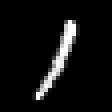

In [2]:
imgs = MNIST.images()
colorview(Gray, imgs[100])

In [3]:
typeof(imgs[3])

Array{Gray{Normed{UInt8,8}},2}

First, we will transofrm the gray scale values to Float32 types. Here, using Float32 will speedup the neural network substantially withough compromising the quality of the solution.

In [6]:
myFloat32(X) = Float32.(X)
fpt_imgs = myFloat32.(imgs) 

60000-element Array{Array{Float32,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0

In [7]:
typeof(fpt_imgs[3])

Array{Float32,2}

We will now create a few helpful functions...

In [8]:
vectorize(x) = x[:]
vectorized_imgs = vectorize.(fpt_imgs);

In [9]:
typeof(vectorized_imgs)

Array{Array{Float32,1},1}

We will again make use of `...` as the splat operator to concatenate all images into one matrix.

In [10]:
X = hcat(vectorized_imgs...)
size(X)

(784, 60000)

Now, every column in `X` is an image of a number. We have `60,000` images. When reshaped into a 28-by-28 matrix, and displayed as an image, can be seen as a handwritten number. Here is an example below.

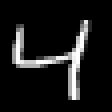

In [11]:
onefigure = X[:,3]
t1 = reshape(onefigure,28,28)
colorview(Gray,t1)

Next, we will obtain the labels. These are the true labels for the `60,000` images.

In [12]:
labels = MNIST.labels()
labels[1]

5

From these labels, we will create a new output column for each image. These columns will be indicator vectors of where the correct label is.

For example if the figure corresponding to column `X[:,i]` is a `3`, the `i'th` column in this new matrix `Y` is `[0 0 0 1 0 0 0 0 0 0]`. (It is the entry number 4 because entry 1 corresponds to the digit 0, so the counting starts from zero). The `onehotbatch` function allows us to create this easily.

In [13]:
Y = onehotbatch(labels, 0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

And now we will actually build our neural network. We will use two layers. The hidden layer will have 32 nodes, and the output layer will have 10 nodes. i.e. we will go from: `28*28 => 32 => 10`.

In [14]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax)

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

What does `m`, the neural network mean here? 

If you've worked with neural networks before you know that the solution is often not found by just one pass on the neural network. One pass happens, and a solution is generated at the output layer, then this solution is compared to the ground truth solution we already have (the columns from `Y`), and the network goes back and adjusts its weights and parameters and then try again. Here, since `m` is not "trained" yet, one pass of `m` on a figure generates the following (not-so-great) answer. We will see later how this changes after training.

In [15]:
m(onefigure)

10-element Array{Float32,1}:
 0.09733525
 0.08215944
 0.083417185
 0.21038684
 0.0866223
 0.075022995
 0.0848846
 0.06997362
 0.14776614
 0.06243159

To run our neural network, we need a loss function and an accuracy function. The accuracy function is used to compare the output result from the output layer in the neural network to the groundtruth result. The loss function is used to evaluate the performance of the overall model after new weights have been recalculated at each pass.

In [16]:
loss(x, y) = Flux.crossentropy(m(x), y)
accuracy(x, y) = mean(argmax(m(x)) .== argmax(y))

accuracy (generic function with 1 method)

Finally, we will repeat our data so that we have more samples to pass to the neural network, which means there will be more chances for corrections.

In [17]:
datasetx = repeated((X, Y), 200)
C = collect(datasetx);

We will create a function to display the loss at each step.

In [18]:
evalcb = () -> @show(loss(X, Y))

#3 (generic function with 1 method)

In [19]:
ps = Flux.params(m)

Params([Float32[0.0071736737 -0.03036321 … 0.032545816 -0.023747275; -0.028356241 -0.083176464 … 0.027189756 0.0400881; … ; 0.082404144 -0.05686704 … -0.08054515 0.039617267; -0.002954497 0.013985546 … 0.078786455 -0.02831656], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.08932363 0.094673775 … -0.17531838 0.13151759; 0.3476475 -0.3684938 … -0.30146545 -0.24876234; … ; -0.15957415 -0.2758126 … -0.0608175 -0.111767635; 0.12899315 -0.11270302 … -0.31407237 -0.08888577], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

Finally, we are ready to train the model, we will use the `Flux.train!` function. Let's take a look at the documentation.

In [20]:
?Flux.train!

```
train!(loss, params, data, opt; cb)
```

For each datapoint `d` in `data` compute the gradient of `loss(d...)` through backpropagation and call the optimizer `opt`.

In case datapoints `d` are of numeric array type, assume no splatting is needed and compute the gradient of `loss(d)`.

A callback is given with the keyword argument `cb`. For example, this will print "training" every 10 seconds (using [`Flux.throttle`](@ref)):

train!(loss, params, data, opt,          cb = throttle(() -> println("training"), 10))

The callback can call [`Flux.stop`](@ref) to interrupt the training loop.

Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.


In [21]:
opt = ADAM()
Flux.train!(loss, ps, datasetx, opt, cb = throttle(evalcb, 10))

loss(X, Y) = 2.2564037f0
loss(X, Y) = 0.9608722f0
loss(X, Y) = 0.5360268f0
loss(X, Y) = 0.4031882f0
loss(X, Y) = 0.34638894f0
loss(X, Y) = 0.31118682f0
loss(X, Y) = 0.2873739f0


We will now get the test data.

In [22]:
tX = hcat(float.(reshape.(MNIST.images(:test), :))...);
test_image = m(tX[:,1])

10-element Array{Float32,1}:
 0.00024723905
 1.2693711f-7
 4.158335f-5
 0.0026686336
 6.259864f-6
 0.000100415775
 2.6722677f-7
 0.99650407
 7.106942f-5
 0.00036042536

In [23]:
argmax(test_image) - 1

7

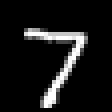

In [24]:
t1 = reshape(tX[:,1],28,28)
colorview(Gray, t1)

What about the image we tried a few cells earlier and returned the "not-so-great" answer.

In [25]:
onefigure = X[:,2]
m(onefigure)

10-element Array{Float32,1}:
 0.998697
 3.4294123f-10
 8.7849956f-5
 0.0001142274
 2.1881644f-7
 0.0008209261
 2.9258348f-5
 8.827988f-5
 0.000115546325
 4.6671623f-5

In [26]:
Y[:,2]

10-element Flux.OneHotVector:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0

# Finally...
After finishing this notebook, you should be able to:
- [ ] prepare data to fit the format to create a neural network using Flux.jl
- [ ] create a neural network with Flux.jl
- [ ] creating an accuracy function and loss function to be passed to train the neural network
- [ ] train the neural network
- [ ] describe a few tips that can help make your nerual network faster or more accurate (such as using Float32 as opposed to Float32)

# 🥳 One cool finding

We ran a trained a neural network on a dataset of of handwritten digits (called the MNIST dataset). At the end, we were able to pass this figure to the neural network and the return result was:

<img src="data/1001.png" width="40">

```
10-element Array{Float32,1}:
 0.00029263002
 1.5993925f-5
 0.0002862561
 0.0035434738
 1.388653f-5
 2.4878627f-5
 6.433018f-7
 0.99414164 ### <= this is the highest number!
 0.000118321994
 0.0015623316
```